In [1]:
import pandas as pd
import nibabel as nib
import numpy as np
import os
import ast

# 1. Load and clean data
df = pd.read_csv('merged_brain_age_hdr.csv', converters={'hdr_paths': ast.literal_eval})
df['hdr_paths'] = df['hdr_paths'].apply(lambda x: [p.strip() for p in x if p.strip()])
df['selected_hdr'] = df['hdr_paths'].apply(lambda x: x[1] if len(x)>=2 else None)
df = df.dropna(subset=['selected_hdr']).reset_index(drop=True)

# 2. Convert to absolute paths
df['selected_hdr'] = df['selected_hdr'].apply(os.path.abspath)

# 3. Validate paths
df = df[df['selected_hdr'].apply(os.path.exists)].reset_index(drop=True)

# 4. Verify sample file
sample_path = df['selected_hdr'].iloc[0]
print(f"Sample path: {sample_path}")
print(f"File exists: {os.path.exists(sample_path)}")

try:
    sample_img = nib.load(sample_path)
    print(f"Image shape: {sample_img.header.get_data_shape()}")
except Exception as e:
    print(f"Error loading sample: {str(e)}")

Sample path: E:\Brain Age prediction\Brain Age prediction\disc1\OAS1_0001_MR1\processed\MPRAGE\T88_111\OAS1_0001_MR1_mpr_n4_anon_111_t88_masked_gfc.hdr
File exists: True
Image shape: (176, 208, 176, 1)


In [3]:
from sklearn.model_selection import train_test_split
import tensorflow as tf



def load_3d_volume(hdr_path, age):
    # Load NIfTI file
    img = nib.load(hdr_path.decode('utf-8')).get_fdata()
    
    # Normalize to [0, 1]
    img = (img - img.min()) / (img.max() - img.min())
    
    # Add channel dimension
    if img.ndim == 3:
        img = np.expand_dims(img, -1)  # Shape (176, 208, 176, 1)
    
    return img.astype(np.float32), np.array(age, dtype=np.float32)

def tf_dataset_generator(hdr_paths, ages):
    dataset = tf.data.Dataset.from_tensor_slices((hdr_paths, ages))
    dataset = dataset.map(
        lambda x, y: tf.numpy_function(
            load_3d_volume, 
            [x, y], 
            [tf.float32, tf.float32]
        ),
        num_parallel_calls=tf.data.AUTOTUNE
    )
    # Add explicit output signature
    dataset = dataset.map(
        lambda x, y: (
            tf.ensure_shape(x, (176, 208, 176, 1)),
            tf.ensure_shape(y, ())
        )
    )
    return dataset

# Split data
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=42)

# Create datasets
batch_size = 1  # Small batch size due to large 3D volumes
train_ds = tf_dataset_generator(train_df['selected_hdr'], train_df['Age'])
train_ds = train_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

val_ds = tf_dataset_generator(val_df['selected_hdr'], val_df['Age'])
val_ds = val_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

test_ds = tf_dataset_generator(test_df['selected_hdr'], test_df['Age'])
test_ds = test_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [14]:
from tensorflow.keras import layers, models

def build_3d_cnn():
    inputs = tf.keras.Input(shape=(176, 208, 176, 1))  # Explicit input shape
    
    x = layers.Conv3D(32, (3, 3, 3), activation='relu')(inputs)
    x = layers.MaxPooling3D((2, 2, 2))(x)
    x = layers.Dropout(0.2)(x)
    
    x = layers.Conv3D(16, (3, 3, 3), activation='relu')(x)
    x = layers.MaxPooling3D((2, 2, 2))(x)
    
    x = layers.Conv3D(8, (3, 3, 3), activation='relu')(x)
    x = layers.MaxPooling3D((2, 2, 2))(x)
    
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1)(x)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(0.001),
        loss='mse',
        metrics=['mae']
    )
    return model

model.compile(optimizer='adam', loss='mse', metrics=['mae', 'mse'])


model = build_3d_cnn()
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 176, 208, 176, 1)    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_3 (Conv3D)                    │ (None, 174, 206, 174, 32)   │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_3 (MaxPooling3D)       │ (None, 87, 103, 87, 32)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 87, 103, 87, 32)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_4 (Conv3D)                    │ (None, 85, 101, 85, 16)     │          13,840 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_4 (MaxPooling3D)       │ (None, 42, 50, 42, 16)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_5 (Conv3D)                    │ (None, 40, 48, 40, 8)       │           3,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_5 (MaxPooling3D)       │ (None, 20, 24, 20, 8)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 76800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │       4,915,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,933,529 (18.82 MB)

 Trainable params: 4,933,529 (18.82 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# Test model with one sample
sample_batch = next(iter(train_ds.take(1)))
print("Input shape:", sample_batch[0].shape)
print("Output shape:", model(sample_batch[0]).shape)

Input shape: (1, 176, 208, 176, 1)
Output shape: (1, 1)


In [10]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5),
    tf.keras.callbacks.ModelCheckpoint('best_3d_cnn.keras', save_best_only=True),
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.05, patience=2)
]

with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=50,
        callbacks=callbacks
    )


Epoch 1/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 90s 285ms/step - loss: 268.8615 - mae: 12.2818 - val_loss: 103.1312 - val_mae: 8.3349 - learning_rate: 1.5000e-04
Epoch 2/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 90s 285ms/step - loss: 318.1902 - mae: 12.9694 - val_loss: 131.1635 - val_mae: 9.4398 - learning_rate: 1.5000e-04
Epoch 3/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 90s 286ms/step - loss: 283.0889 - mae: 12.4419 - val_loss: 161.3098 - val_mae: 10.5450 - learning_rate: 1.5000e-04
Epoch 4/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 90s 285ms/step - loss: 355.9450 - mae: 14.4514 - val_loss: 109.6167 - val_mae: 8.5936 - learning_rate: 2.2500e-05
Epoch 5/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 90s 288ms/step - loss: 267.4423 - mae: 12.5114 - val_loss: 91.8665 - val_mae: 7.8260 - learning_rate: 2.2500e-05
Epoch 6/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 90s 285ms/step - loss: 297.0360 - mae: 12.9378 - val_loss: 93.1053 - val_mae: 7.9040 - learning_rate: 2.2500e-05
Epoch 7/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 89s 283ms/step - loss: 312.2928 - mae

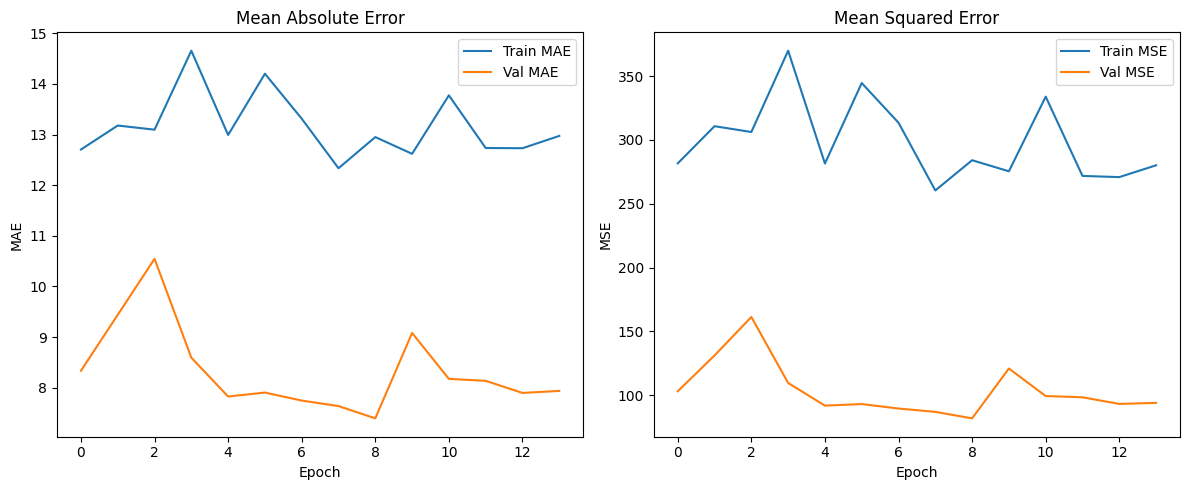

In [18]:
import matplotlib.pyplot as plt

# Assuming you trained the model and stored the history:
# history = model.fit(...)

plt.figure(figsize=(12, 5))

# MAE Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.title('Mean Absolute Error')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

# MSE Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train MSE')
plt.plot(history.history['val_loss'], label='Val MSE')
plt.title('Mean Squared Error')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()

plt.tight_layout()
plt.show()
